# code for constructing the CHINESE 2023 regressors
- donald dunagan
- 13 Jan 2023

### Imports

In [1]:
import math

import pandas as pd

import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg as npl

from nilearn.glm.first_level import compute_regressor

from scipy.stats import pearsonr

import seaborn as sns

%matplotlib inline

/home/dgd45125/.local/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [2]:
sns.set(rc={'figure.figsize':(17,8)})

# Calculate Regressors

In [3]:
'''
This code is from Christophe Pallier:
https://github.com/chrplr/lpp-scripts3/blob/master/models/en/bottomup-topdown-ortho/orthonormalize.py
'''
def ortho_proj(Y, M):
    """ returns the orthogonal component of Y to the space spanned by M and the constant vector 1 """
    if M.ndim == 1:   # M is a vector but needs to be a 2-D matrix
        M = M[:, np.newaxis]
    I = np.ones(len(M))
    I = I[:, np.newaxis]
    M2 = np.hstack((I, M))  # adding the constant 
    betas,_,_,_ = npl.lstsq(M2, Y, rcond=None)
    Xc = np.dot(M2, betas)  # colinear component "residuals"
    Xo = Y - Xc
    return Xo

## read in the prosody spreadsheet

In [4]:
#read in the prosody spreadsheet
prosody_spreadsheet = pd.read_csv('annotation_CN_lppCN_prosody.csv').drop(columns=['Unnamed: 0'])
prosody_spreadsheet

,time,f0,intensity,section
0,0.01,0.00,0.00,1
1,0.02,0.00,0.00,1
2,0.03,0.00,0.00,1
3,0.04,151.11,0.04,1
4,0.05,310.18,0.10,1
...,...,...,...,...
595402,801.97,0.00,0.00,9
595403,801.98,0.00,0.00,9
595404,801.99,0.00,0.00,9
595405,802.00,0.00,0.00,9


## read in the (MOST RECENT) word complexities spreadsheet
- Use Milos' rule system to pull the WH questions and Relative Clause items
- Subject relatives are Rule 5
- Object relatives are Rule 6
- WH questions are Rule 7

In [8]:
complexity_spreadsheet = pd.read_csv('COMPLEXITIES__ch_9apr2022.csv')

#the spreadsheet has 59 -inf in the logfreq column (presumably out of vocabulary items), so I just give them a low probability
complexity_spreadsheet.replace(float('-inf'),-5,inplace=True)
complexity_spreadsheet

,Unnamed: 0,word,lemma,onset,offset,logfreq,pos,section,top_down,bottom_up,...,new-proj-filler-gap,new-proj-filler-gap-only-filler,new-proj-filler-gap-only-gap,new-proj-filler-gap-only-rule-1,new-proj-filler-gap-only-rule-2,new-proj-filler-gap-only-rule-3,new-proj-filler-gap-only-rule-4,new-proj-filler-gap-only-rule-5,new-proj-filler-gap-only-rule-6,new-proj-filler-gap-only-rule-7
0,0,当,当,0.00,0.14,8.529403,ADP,1,3,1,...,0,0,0,0,0,0,0,0,0,0
1,1,我,我,0.14,0.25,10.534098,PRON,1,5,2,...,0,0,0,0,0,0,0,0,0,0
2,2,还,还,0.25,0.43,9.872624,ADV,1,3,2,...,0,0,0,0,0,0,0,0,0,0
3,3,只有,只有,0.43,0.67,8.511888,ADV,1,2,1,...,0,0,0,0,0,0,0,0,0,0
4,4,六,六,0.67,0.89,8.930712,NUM,1,2,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16004,16004,我,我,799.48,799.69,10.534098,PRON,9,3,2,...,0,0,0,0,0,0,0,0,0,0
16005,16005,他,他,800.25,800.41,10.667244,PRON,9,2,2,...,0,0,0,0,0,0,0,0,0,0
16006,16006,又,又,800.41,800.52,9.206757,ADV,9,3,2,...,0,0,0,0,0,0,0,0,0,0
16007,16007,回来,回来,800.52,800.88,6.681417,VERB,9,2,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
count = 0
inside = False

for i in range(len(complexity_spreadsheet)):
    
    if complexity_spreadsheet.iloc[i]['new-disc-filler-gap-only-rule-5']>=1 and inside ==False:
        count+=1
        inside=True
        
    if  complexity_spreadsheet.iloc[i]['new-disc-filler-gap-only-rule-5']==0 and inside==True:
        inside=False

print(f"Subject relatives: {count}")


count=0
for i in range(len(complexity_spreadsheet)):
    
    if complexity_spreadsheet.iloc[i]['new-disc-filler-gap-only-rule-6']>=1 and inside ==False:
        count+=1
        inside=True
        
    if  complexity_spreadsheet.iloc[i]['new-disc-filler-gap-only-rule-6']==0 and inside==True:
        inside=False

print(f"Object relatives: {count}")



count=0
for i in range(len(complexity_spreadsheet)):
    
    if complexity_spreadsheet.iloc[i]['new-disc-filler-gap-only-rule-7']>=1 and inside ==False:
        count+=1
        inside=True
        
    if  complexity_spreadsheet.iloc[i]['new-disc-filler-gap-only-rule-7']==0 and inside==True:
        inside=False
        
print(f"WH:  {count}")

Subject relatives: 34
Object relatives: 33
WH:  85


In [14]:
len(complexity_spreadsheet[complexity_spreadsheet['new-disc-filler-gap']>=1])

497

### Subject Relatives

In [9]:
complexity_spreadsheet[complexity_spreadsheet['new-disc-filler-gap-only-rule-5']>=1]

,Unnamed: 0,word,lemma,onset,offset,logfreq,pos,section,top_down,bottom_up,...,new-proj-filler-gap,new-proj-filler-gap-only-filler,new-proj-filler-gap-only-gap,new-proj-filler-gap-only-rule-1,new-proj-filler-gap-only-rule-2,new-proj-filler-gap-only-rule-3,new-proj-filler-gap-only-rule-4,new-proj-filler-gap-only-rule-5,new-proj-filler-gap-only-rule-6,new-proj-filler-gap-only-rule-7
11,11,描写,描写,2.53,2.93,6.134109,NOUN,1,2,3,...,1,1,0,0,0,0,0,1,0,0
12,12,原始,原始,2.93,3.25,6.904484,ADJ,1,2,2,...,1,0,0,0,0,0,0,1,0,0
13,13,森林,森林,3.25,3.69,6.496140,NOUN,1,2,3,...,1,0,0,0,0,0,0,1,0,0
14,14,的,的,3.69,3.79,13.549002,PART,1,1,2,...,1,0,0,0,0,0,0,1,0,0
15,15,名,名,4.16,4.30,8.351762,NOUN,1,2,3,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15314,15314,辘轳,辘轳,530.40,530.68,-4.509860,NOUN,9,2,5,...,1,0,1,0,0,0,0,1,0,0
15753,15753,喜欢,喜欢,706.12,706.40,6.993155,VERB,9,2,1,...,1,1,0,0,0,0,0,1,0,0
15754,15754,小王子,小王子,706.40,706.84,-0.807436,NOUN,9,4,2,...,1,0,0,0,0,0,0,1,0,0
15755,15755,的,的,706.84,706.96,13.549002,PART,9,1,2,...,1,0,0,0,0,0,0,1,0,0


### Object Relatives

In [10]:
complexity_spreadsheet[complexity_spreadsheet['new-disc-filler-gap-only-rule-6']>=1]

,Unnamed: 0,word,lemma,onset,offset,logfreq,pos,section,top_down,bottom_up,...,new-proj-filler-gap,new-proj-filler-gap-only-filler,new-proj-filler-gap-only-gap,new-proj-filler-gap-only-rule-1,new-proj-filler-gap-only-rule-2,new-proj-filler-gap-only-rule-3,new-proj-filler-gap-only-rule-4,new-proj-filler-gap-only-rule-5,new-proj-filler-gap-only-rule-6,new-proj-filler-gap-only-rule-7
402,402,稍微,稍微,126.64,126.88,3.470008,ADV,1,4,2,...,1,1,0,0,0,0,0,0,1,0
403,403,清楚,清楚,126.88,127.23,7.317524,VERB,1,2,1,...,1,0,0,0,0,0,0,0,1,0
404,404,的,的,127.23,127.30,13.549002,PART,1,1,3,...,1,0,0,0,0,0,0,0,1,0
405,405,大人,大人,127.30,127.59,4.335040,NOUN,1,2,8,...,1,0,1,0,0,0,0,0,1,0
1032,1032,的,的,329.72,329.81,13.549002,PART,1,1,2,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14278,14278,鸟,鸟,124.18,124.39,4.138106,NOUN,9,2,7,...,1,0,1,0,0,0,0,0,1,0
14427,14427,的,的,180.39,180.53,13.549002,PART,9,1,2,...,1,1,0,0,0,0,0,0,1,0
14428,14428,羊,羊,180.53,180.80,3.800980,NOUN,9,2,4,...,1,0,1,0,0,0,0,0,1,0
14840,14840,的,的,344.17,344.26,13.549002,PART,9,1,2,...,1,1,0,0,0,0,0,0,1,0


## Subject and Object Relatives

In [15]:
complexity_spreadsheet[(complexity_spreadsheet['new-disc-filler-gap-only-rule-5']==1)|(complexity_spreadsheet['new-disc-filler-gap-only-rule-6']>=1)]

,Unnamed: 0,word,lemma,onset,offset,logfreq,pos,section,top_down,bottom_up,...,new-proj-filler-gap,new-proj-filler-gap-only-filler,new-proj-filler-gap-only-gap,new-proj-filler-gap-only-rule-1,new-proj-filler-gap-only-rule-2,new-proj-filler-gap-only-rule-3,new-proj-filler-gap-only-rule-4,new-proj-filler-gap-only-rule-5,new-proj-filler-gap-only-rule-6,new-proj-filler-gap-only-rule-7
11,11,描写,描写,2.53,2.93,6.134109,NOUN,1,2,3,...,1,1,0,0,0,0,0,1,0,0
12,12,原始,原始,2.93,3.25,6.904484,ADJ,1,2,2,...,1,0,0,0,0,0,0,1,0,0
13,13,森林,森林,3.25,3.69,6.496140,NOUN,1,2,3,...,1,0,0,0,0,0,0,1,0,0
14,14,的,的,3.69,3.79,13.549002,PART,1,1,2,...,1,0,0,0,0,0,0,1,0,0
15,15,名,名,4.16,4.30,8.351762,NOUN,1,2,3,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15314,15314,辘轳,辘轳,530.40,530.68,-4.509860,NOUN,9,2,5,...,1,0,1,0,0,0,0,1,0,0
15753,15753,喜欢,喜欢,706.12,706.40,6.993155,VERB,9,2,1,...,1,1,0,0,0,0,0,1,0,0
15754,15754,小王子,小王子,706.40,706.84,-0.807436,NOUN,9,4,2,...,1,0,0,0,0,0,0,1,0,0
15755,15755,的,的,706.84,706.96,13.549002,PART,9,1,2,...,1,0,0,0,0,0,0,1,0,0


In [17]:
count = 0
for val in complexity_spreadsheet['new-disc-filler-gap-only-rule-5']+complexity_spreadsheet['new-disc-filler-gap-only-rule-6']:
    if val >=1:
        count+=1
count

255

### WH questions

In [18]:
complexity_spreadsheet[complexity_spreadsheet['new-disc-filler-gap-only-rule-7']>=1]

,Unnamed: 0,word,lemma,onset,offset,logfreq,pos,section,top_down,bottom_up,...,new-proj-filler-gap,new-proj-filler-gap-only-filler,new-proj-filler-gap-only-gap,new-proj-filler-gap-only-rule-1,new-proj-filler-gap-only-rule-2,new-proj-filler-gap-only-rule-3,new-proj-filler-gap-only-rule-4,new-proj-filler-gap-only-rule-5,new-proj-filler-gap-only-rule-6,new-proj-filler-gap-only-rule-7
156,156,什么,什么,48.84,49.11,9.138085,DET,1,3,2,...,1,1,0,0,0,0,0,0,0,1
157,157,可怕,可怕,49.11,49.48,-2.513306,ADJ,1,2,5,...,1,0,0,0,0,0,0,0,0,1
158,158,的,的,49.48,49.60,13.549002,PART,1,1,6,...,1,0,1,0,0,0,0,0,0,1
845,845,什么,什么,268.61,268.91,9.138085,PRON,1,2,8,...,1,1,1,0,0,0,0,0,0,1
1217,1217,为什么,为什么,392.87,393.29,7.606331,ADV,1,3,3,...,1,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14792,14792,什么,什么,325.72,326.04,9.138085,DET,9,2,4,...,1,1,1,0,0,0,0,0,0,1
14882,14882,什么,什么,359.75,360.07,9.138085,PRON,9,2,4,...,1,1,1,0,0,0,0,0,0,1
15640,15640,什么,什么,664.28,664.51,9.138085,DET,9,3,2,...,1,1,0,0,0,0,0,0,0,1
15641,15641,事儿,事,664.51,664.74,8.539651,NOUN,9,2,6,...,1,0,0,0,0,0,0,0,0,1


## read in the Chinese GPT surprisals

In [9]:
chinese_gpt2_surprisal_sheet = pd.read_csv('lpp_CN_word_surprisal_gpt2.csv')
chinese_gpt2_surprisal_sheet

,word,lemma,onset,offset,logfreq,pos,section,top_down,bottom_up,left_corner,sentence_id,surprisal
0,当,当,0.00,0.14,8.529403,ADP,1,3,1,2,1,2.797432
1,我,我,0.14,0.25,10.534098,PRON,1,5,2,3,1,1.664712
2,还,还,0.25,0.43,9.872624,ADV,1,3,2,3,1,2.120358
3,只有,只有,0.43,0.67,8.511888,ADV,1,2,1,2,1,5.843334
4,六,六,0.67,0.89,8.930712,NUM,1,2,1,2,1,3.692552
...,...,...,...,...,...,...,...,...,...,...,...,...
16004,我,我,799.48,799.69,10.534098,PRON,9,3,2,3,2801,1.706752
16005,他,他,800.25,800.41,10.667244,PRON,9,2,2,2,2802,2.701978
16006,又,又,800.41,800.52,9.206757,ADV,9,3,2,3,2802,3.040581
16007,回来,回来,800.52,800.88,6.681417,VERB,9,2,1,2,2802,4.881083


In [20]:
count = 0
for i in range(len(complexity_spreadsheet)):
    if complexity_spreadsheet.iloc[i].word != complexity_spreadsheet.iloc[i].lemma:
        count +=1
count
    

284

# Semantics

In [13]:
import fasttext.util
fasttext.util.download_model('zh', if_exists='ignore')
ft = fasttext.load_model('cc.zh.300.bin') 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 (100.00%) [==================================================>]================================================> ]


In [14]:
fasttext.util.reduce_model(ft,5)

In [24]:
ft.get_word_vector('只有')

array([ 0.02264726,  0.5701983 , -0.22738226,  0.18654954,  0.07195828],
      dtype=float32)

In [22]:
df = pd.DataFrame(columns=['dim1','dim2','dim3','dim4','dim5'])

for word in complexity_spreadsheet.lemma:
    df.loc[len(df.index)] = ft.get_word_vector(word)

df

,dim1,dim2,dim3,dim4,dim5
0,0.701511,0.271017,-0.340579,-0.571221,0.136801
1,0.044928,0.186645,0.039985,0.222779,-0.171206
2,0.694071,0.209915,-0.710502,-0.535345,0.207298
3,0.022647,0.570198,-0.227382,0.186550,0.071958
4,0.051728,0.658576,0.769276,-0.298056,0.213066
...,...,...,...,...,...
16004,0.044928,0.186645,0.039985,0.222779,-0.171206
16005,-0.005141,0.314443,-0.006226,0.223106,0.177285
16006,0.047272,0.504690,-0.282559,0.196895,0.145825
16007,0.778596,0.011483,-0.794258,-0.417910,-0.048568


In [23]:
semandf = pd.concat([complexity_spreadsheet[['word','offset','section']],df],axis=1)
semandf

,word,offset,section,dim1,dim2,dim3,dim4,dim5
0,当,0.14,1,0.701511,0.271017,-0.340579,-0.571221,0.136801
1,我,0.25,1,0.044928,0.186645,0.039985,0.222779,-0.171206
2,还,0.43,1,0.694071,0.209915,-0.710502,-0.535345,0.207298
3,只有,0.67,1,0.022647,0.570198,-0.227382,0.186550,0.071958
4,六,0.89,1,0.051728,0.658576,0.769276,-0.298056,0.213066
...,...,...,...,...,...,...,...,...
16004,我,799.69,9,0.044928,0.186645,0.039985,0.222779,-0.171206
16005,他,800.41,9,-0.005141,0.314443,-0.006226,0.223106,0.177285
16006,又,800.52,9,0.047272,0.504690,-0.282559,0.196895,0.145825
16007,回来,800.88,9,0.778596,0.011483,-0.794258,-0.417910,-0.048568


In [26]:
ft.get_word_vector('回来')

array([ 0.77859586,  0.01148317, -0.7942576 , -0.41790983, -0.04856807],
      dtype=float32)

In [27]:
#number of volumes in each section
n_scans = [283,322,322,307,293,392,364,293,401]

In [28]:
sum(n_scans)

2977

## Regressors

In [29]:
def convolve_regressors(section_num): 

    regressors_df = pd.DataFrame()
    '''
    compute_regressor() arguments:
        exp_condition: matrix of size 3 x num_events which consists of ('onsets', durations, amplitudes)
        hrf_model: use spm
        frame_times: the sampling times

    regressors of interest are orthogonalized against word_rate
    '''
    #########
    #regressors of non-interest
    #########

    #word rate
    word_rate = compute_regressor(exp_condition = np.vstack((complexity_spreadsheet[complexity_spreadsheet['section']==section_num].offset,
                                                               np.zeros(len(complexity_spreadsheet[complexity_spreadsheet['section']==section_num])),
                                                               np.ones(len(complexity_spreadsheet[complexity_spreadsheet['section']==section_num])) )),
                                                  hrf_model="spm",
                                                  frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]

    
    #RMS
    rms = compute_regressor(exp_condition = np.vstack((prosody_spreadsheet[prosody_spreadsheet['section']==section_num].time,
                                                               np.zeros(len(prosody_spreadsheet[prosody_spreadsheet['section']==section_num])),
                                                               prosody_spreadsheet[prosody_spreadsheet['section']==section_num].intensity)),
                                                  hrf_model="spm",
                                                  frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]


    #freq
    freq = compute_regressor(exp_condition = np.vstack((complexity_spreadsheet[complexity_spreadsheet['section']==section_num].offset,
                                                               np.zeros(len(complexity_spreadsheet[complexity_spreadsheet['section']==section_num])),
                                                               complexity_spreadsheet[complexity_spreadsheet['section']==section_num].logfreq)),
                                                  hrf_model="spm",
                                                  frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]

    #f0
    f0 = compute_regressor(exp_condition = np.vstack((prosody_spreadsheet[prosody_spreadsheet['section']==section_num].time,
                                                           np.zeros(len(prosody_spreadsheet[prosody_spreadsheet['section']==section_num])),
                                                           prosody_spreadsheet[prosody_spreadsheet['section']==section_num].f0)),
                                              hrf_model="spm",
                                              frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]



    ############################
    #regressors of interest
    ############################
    
    #filler-gap
    disc_filler_gap = compute_regressor(exp_condition = np.vstack((complexity_spreadsheet[complexity_spreadsheet['section']==section_num].offset,
                                                                   np.zeros(len(complexity_spreadsheet[complexity_spreadsheet['section']==section_num])),
                                                                   complexity_spreadsheet[complexity_spreadsheet['section']==section_num]['new-disc-filler-gap']
                                                                      )),
                                                      hrf_model="spm",
                                                      frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]
    disc_filler_gap = ortho_proj(disc_filler_gap,word_rate)
    
    #(complexity_spreadsheet[complexity_spreadsheet['section']==section_num]['new-disc-filler-gap-only-rule-5']+complexity_spreadsheet[complexity_spreadsheet['section']==section_num]['new-disc-filler-gap-only-rule-6'])
    #relative clauses
    relatives = compute_regressor(exp_condition = np.vstack((complexity_spreadsheet[complexity_spreadsheet['section']==section_num].offset,
                                                                   np.zeros(len(complexity_spreadsheet[complexity_spreadsheet['section']==section_num])),
                                                                   (complexity_spreadsheet[complexity_spreadsheet['section']==section_num]['new-disc-filler-gap-only-rule-5']+complexity_spreadsheet[complexity_spreadsheet['section']==section_num]['new-disc-filler-gap-only-rule-6'])
                                                                      )),
                                                      hrf_model="spm",
                                                      frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]
    relatives = ortho_proj(relatives,word_rate)
    
    #object relatives
    obj_relatives = compute_regressor(exp_condition = np.vstack((complexity_spreadsheet[complexity_spreadsheet['section']==section_num].offset,
                                                                   np.zeros(len(complexity_spreadsheet[complexity_spreadsheet['section']==section_num])),
                                                                   complexity_spreadsheet[complexity_spreadsheet['section']==section_num]['new-disc-filler-gap-only-rule-6']
                                                                      )),
                                                      hrf_model="spm",
                                                      frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]
    obj_relatives = ortho_proj(obj_relatives,word_rate)    
    
    
    #subject relatives
    subj_relatives = compute_regressor(exp_condition = np.vstack((complexity_spreadsheet[complexity_spreadsheet['section']==section_num].offset,
                                                                   np.zeros(len(complexity_spreadsheet[complexity_spreadsheet['section']==section_num])),
                                                                   complexity_spreadsheet[complexity_spreadsheet['section']==section_num]['new-disc-filler-gap-only-rule-5']
                                                                      )),
                                                      hrf_model="spm",
                                                      frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]
    subj_relatives = ortho_proj(subj_relatives,word_rate)         
    
    
    #WH questions
    WH = compute_regressor(exp_condition = np.vstack((complexity_spreadsheet[complexity_spreadsheet['section']==section_num].offset,
                                                                   np.zeros(len(complexity_spreadsheet[complexity_spreadsheet['section']==section_num])),
                                                                   complexity_spreadsheet[complexity_spreadsheet['section']==section_num]['new-disc-filler-gap-only-rule-7']
                                                                      )),
                                                      hrf_model="spm",
                                                      frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]
    WH = ortho_proj(WH,word_rate)    
    
    
    
    #new-proj-old-bu
    projective_bottomup = compute_regressor(exp_condition = np.vstack((complexity_spreadsheet[complexity_spreadsheet['section']==section_num].offset,
                                                                   np.zeros(len(complexity_spreadsheet[complexity_spreadsheet['section']==section_num])),
                                                                   complexity_spreadsheet[complexity_spreadsheet['section']==section_num]['new-proj-old-bu']
                                                                      )),
                                                      hrf_model="spm",
                                                      frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]
    projective_bottomup = ortho_proj(projective_bottomup,word_rate)
    
 

    #semantics
    seman_dim1 = compute_regressor(exp_condition = np.vstack((semandf[semandf['section']==section_num].offset,
                                                                   np.zeros(len(semandf[semandf['section']==section_num])),
                                                                   semandf[semandf['section']==section_num].dim1
                                                                      )),
                                                      hrf_model="spm",
                                                      frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]
    seman_dim1 = ortho_proj(seman_dim1,word_rate)
    
    seman_dim2 = compute_regressor(exp_condition = np.vstack((semandf[semandf['section']==section_num].offset,
                                                                   np.zeros(len(semandf[semandf['section']==section_num])),
                                                                   semandf[semandf['section']==section_num].dim2
                                                                      )),
                                                      hrf_model="spm",
                                                      frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]
    seman_dim2 = ortho_proj(seman_dim2,word_rate)
    
    seman_dim3 = compute_regressor(exp_condition = np.vstack((semandf[semandf['section']==section_num].offset,
                                                                   np.zeros(len(semandf[semandf['section']==section_num])),
                                                                   semandf[semandf['section']==section_num].dim3
                                                                      )),
                                                      hrf_model="spm",
                                                      frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]
    seman_dim3 = ortho_proj(seman_dim3,word_rate)
    
    seman_dim4 = compute_regressor(exp_condition = np.vstack((semandf[semandf['section']==section_num].offset,
                                                                   np.zeros(len(semandf[semandf['section']==section_num])),
                                                                   semandf[semandf['section']==section_num].dim4
                                                                      )),
                                                      hrf_model="spm",
                                                      frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]
    seman_dim4 = ortho_proj(seman_dim4,word_rate)

    seman_dim5 = compute_regressor(exp_condition = np.vstack((semandf[semandf['section']==section_num].offset,
                                                                   np.zeros(len(semandf[semandf['section']==section_num])),
                                                                   semandf[semandf['section']==section_num].dim5
                                                                      )),
                                                      hrf_model="spm",
                                                      frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]
    seman_dim5 = ortho_proj(seman_dim5,word_rate)







    
    
    #Chinese GPT-2 surprisal
    chinese_gpt2_surprisal = compute_regressor(exp_condition = np.vstack((chinese_gpt2_surprisal_sheet[chinese_gpt2_surprisal_sheet['section']==section_num].offset,
                                                                   np.zeros(len(chinese_gpt2_surprisal_sheet[chinese_gpt2_surprisal_sheet['section']==section_num])),
                                                                   chinese_gpt2_surprisal_sheet[chinese_gpt2_surprisal_sheet['section']==section_num].surprisal
                                                                      )),
                                                      hrf_model="spm",
                                                      frame_times = np.arange(0.0, n_scans[section_num-1] * 2.0, 2.0))[0]
    chinese_gpt2_surprisal = ortho_proj(chinese_gpt2_surprisal,word_rate)
    
    
    #store all of the  regressors
    regressors_df['word_rate']=word_rate.flatten()
    regressors_df['rms']=rms.flatten()
    regressors_df['freq']=freq.flatten()
    regressors_df['f0']=f0.flatten()

    regressors_df['disc_filler_gap']=disc_filler_gap.flatten()
    regressors_df['relatives']=relatives.flatten()   
    regressors_df['obj_relatives']=obj_relatives.flatten()   
    regressors_df['subj_relatives']=subj_relatives.flatten()   
    regressors_df['WH']=WH.flatten()    

    regressors_df['projective_bottomup']=projective_bottomup.flatten()     
        
    regressors_df['chinese_gpt2_surprisal']= chinese_gpt2_surprisal.flatten()
    
    regressors_df['seman_dim1'] = seman_dim1.flatten()
    regressors_df['seman_dim2'] = seman_dim2.flatten()
    regressors_df['seman_dim3'] = seman_dim3.flatten()
    regressors_df['seman_dim4'] = seman_dim4.flatten()
    regressors_df['seman_dim5'] = seman_dim5.flatten()    
    
    
    
    regressors_df['section']=[section_num]*n_scans[section_num-1]
    
    return regressors_df

In [30]:
big_data = pd.DataFrame()
sections=[1,2,3,4,5,6,7,8,9]
for i in sections:
    data = convolve_regressors(i)
    big_data = big_data.append(data)

In [31]:
big_data

,word_rate,rms,freq,f0,disc_filler_gap,relatives,obj_relatives,subj_relatives,WH,projective_bottomup,chinese_gpt2_surprisal,seman_dim1,seman_dim2,seman_dim3,seman_dim4,seman_dim5,section
0,0.000000,0.000000,0.000000,0.000000,0.010207,0.012924,0.002593,0.010331,-0.002717,0.020244,-0.089760,-0.005528,-0.000417,0.005681,0.001223,0.008384,1
1,0.003681,0.005161,0.034694,16.586025,0.009740,0.012417,0.002482,0.009935,-0.002677,0.017211,-0.091427,-0.004904,0.000037,0.005609,0.000134,0.008221,1
2,0.044814,0.062256,0.430535,228.376025,0.004698,0.006919,0.001235,0.005685,-0.002221,0.004095,-0.097853,0.000204,0.005255,0.006613,-0.011601,0.007721,1
3,0.100376,0.157604,0.955583,594.716556,0.012776,0.014382,-0.000449,0.014831,-0.001606,-0.008063,-0.075665,0.001853,0.008929,0.009952,-0.020627,0.010139,1
4,0.142764,0.243327,1.327561,866.861677,0.058507,0.059643,-0.001734,0.061377,-0.001137,-0.006474,-0.041610,-0.004170,0.004304,0.012432,-0.013367,0.011784,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0.088587,0.153884,0.759426,916.973736,-0.001189,-0.000667,-0.000235,-0.000432,-0.000522,-0.001216,-0.009229,-0.007106,0.000495,0.004556,0.004296,-0.002697,9
397,0.104723,0.166189,0.920115,874.126927,-0.001791,-0.001143,-0.000447,-0.000696,-0.000647,-0.003501,-0.019401,0.001696,-0.004631,-0.000744,-0.005908,-0.004852,9
398,0.130164,0.166403,1.164731,860.597393,-0.002740,-0.001895,-0.000782,-0.001112,-0.000845,-0.003381,-0.033397,0.005717,0.000892,-0.009410,-0.006587,-0.006696,9
399,0.148257,0.162883,1.304770,854.366261,-0.003415,-0.002429,-0.001021,-0.001408,-0.000986,-0.000174,-0.061724,0.007645,0.007110,-0.012980,-0.006373,-0.005150,9


In [33]:
big_data.to_csv('lpp_cn_regressors_13Jan2023.tsv',index=False,sep='\t')


## Correlations

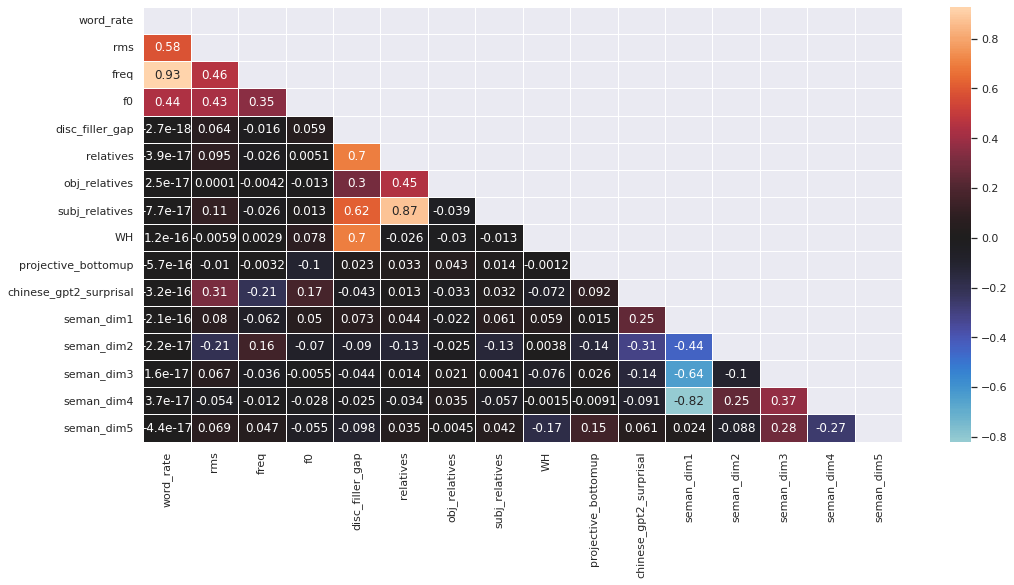

In [32]:
corr = big_data.drop(columns=['section',
        ]).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
picture = sns.heatmap(corr,center=0,linewidth=.5,mask=mask,annot=True)
#figure = picture.get_figure()

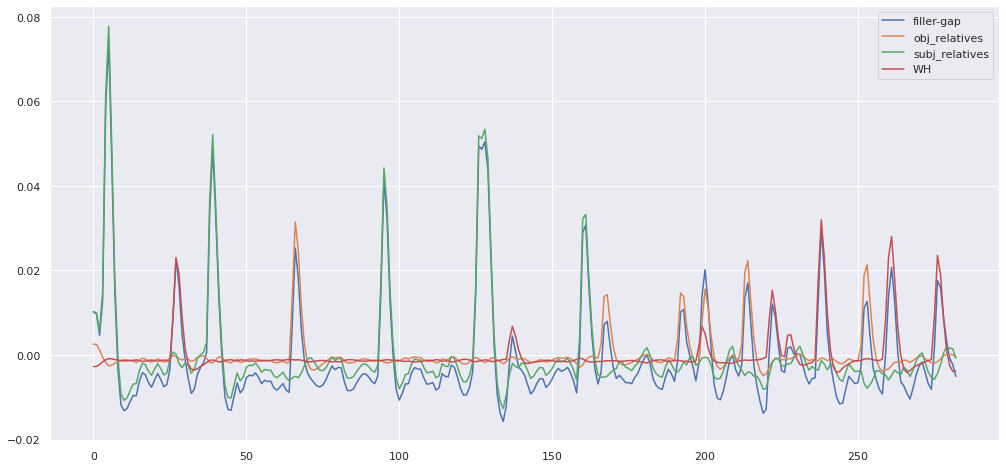

In [43]:
section =1

plt.plot(big_data[big_data.section==section].disc_filler_gap,label='filler-gap')
#plt.plot(big_data[big_data.section==section].relatives,label='relatives')
plt.plot(big_data[big_data.section==section].obj_relatives,label='obj_relatives')
plt.plot(big_data[big_data.section==section].subj_relatives,label='subj_relatives')
plt.plot(big_data[big_data.section==section].WH,label='WH')
plt.legend()
plt.show()